# AI_campus_ProstateSeg 
# Module 4: Pytorch dataset class and data loaders
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

This notebook walks through using the dataset and data loader classes in PyTorch in order to process tiles from whole slide images and feed them to machine learning models

## 1. Import the necessary packages

In [7]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch

from PIL import Image
from typing import List, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset

## 2. Define folder and subdirectory folder names

In [3]:
ROOT_FOLDER = "sample_data"
IMAGE_SUBFOLDER = "train_images"
MASK_SUBFOLDER = "train_label_masks"

image_dir = os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER)
mask_dir = os.path.join(ROOT_FOLDER, MASK_SUBFOLDER)

## 3. Create list of image and mask files and print contents

In [62]:
image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(image_dir))))
mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(mask_dir))))

In [63]:
image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

In [61]:
mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

In [39]:
def tile_qualifier(tile_mask: np.ndarray,
                   min_thresh: float = 0.5):
    
    signal_ratio = (tile_mask > 0).sum()/tile_mask.size
    
    return signal_ratio >= min_thresh

In [210]:
class ToyPANDASDataset(Dataset):
    
    def __init__(self,
                 image_dir: str,
                 mask_dir: str, 
                 root_dir: str,
                 tile_qualifier,
                 mask_suffix: str = "_mask",
                 imfile_ext: str = ".tiff",
                 maskfile_ext: str = ".tiff",
                 tile_size: int = 224,
                 channel_idx: int = 0,
                 transform = None):
        
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.root_dir = root_dir
        self.mask_suffix = mask_suffix
        self.imfile_ext = imfile_ext
        self.maskfile_ext = maskfile_ext
        self.transform = transform
        self.tile_qualifier = tile_qualifier
        self.tile_size = tile_size
        self.full_mask_ext = self.mask_suffix + self.maskfile_ext
        self.channel_idx = channel_idx
        self.image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.image_dir))))
        self.mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.mask_dir))))
        self.n_tiles_processed = 0
        self.n_qualifying_tiles = 0
        self.imtile_coords = self.get_imtile_coords()
        
    def extract_raw_regid(self,
                          filename: str,
                          ext: str) -> str:
        i = 1
        while filename[-i:] != ext:
            i += 1
        return filename[0:len(filename)-i]
    
    def extract_nonoverlapping_tile_coords(self,
                                           mask: np.ndarray):
        
        mask = mask[:,:,self.channel_idx]
        assert len(mask.shape) == 2
        R, C = mask.shape
        tile_coords = []
        for i in range(0, R, self.tile_size):
            for j in range(0, C, self.tile_size):
                try:
                    tile = mask[i : i + self.tile_size, j : j + self.tile_size]
                    self.n_tiles_processed += 1
                    if tile.shape == (self.tile_size, self.tile_size) and self.tile_qualifier(tile):
                        tile_coords.append((i, j))
                        self.n_qualifying_tiles += 1
                except IndexError:
                    print(f"Skipping tile at position ({i}, {j}) because it is out of bounds.")
                        
        return tile_coords
    
    def get_imtile_coords(self):
        
        imtile_coords = []
        
        for imfile in self.image_files:
            regid = self.extract_raw_regid(imfile, self.imfile_ext)
            mask_file = regid + self.full_mask_ext
            mask = tifffile.imread(os.path.join(self.mask_dir, mask_file))
            tile_coords = self.extract_nonoverlapping_tile_coords(mask)
            imtile_coord = list(map(lambda tup : (imfile,) + tup, tile_coords))
            imtile_coords.extend(imtile_coord)
            
        self.tile_qualifying_ratio = self.n_qualifying_tiles / self.n_tiles_processed
        print(f"Total number of tiles processed: {self.n_tiles_processed}")
        print(f"Tile qualifying ratio: {self.tile_qualifying_ratio}")
        print(f"Average number of tiles processed per image or mask: {self.n_tiles_processed/len(self.image_files)}")
        print(f"Average number of tiles qualifying per image or mask: {self.n_qualifying_tiles/len(self.image_files)}")
        
        imfiles = set([t[0] for t in imtile_coords])
        assert imfiles == set(self.image_files)
        i_vals = sorted(list(set([t[1] for t in imtile_coords])))
        j_vals = sorted(list(set([t[2] for t in imtile_coords])))
        
        for i in range(len(i_vals)-1):
            assert i_vals[i + 1] - i_vals[i] == self.tile_size
        
        for j in range(len(j_vals)-1):
            assert j_vals[j + 1] - j_vals[j] == self.tile_size
            
        return imtile_coords
        
    def __len__(self):
        return len(self.imtile_coords)
    
    def __getitem__(self, idx):
        
        image_file, tile_i, tile_j = self.imtile_coords[idx]
        image = tifffile.imread(os.path.join(self.image_dir, image_file))
        tile = image[tile_i: tile_i + self.tile_size, tile_j: tile_j + self.tile_size, :]
        
        if self.transform:
            tile = self.transform(tile)
            
        return tile

In [211]:
panda_dataset = ToyPANDASDataset(image_dir = image_dir,
                                 mask_dir = mask_dir,
                                 root_dir = ROOT_FOLDER,
                                 tile_qualifier = tile_qualifier)

Total number of tiles processed: 38593
Tile qualifying ratio: 0.15458761951649264
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 596.6


In [212]:
panda_loader = DataLoader(panda_dataset, batch_size=16, shuffle=True)

In [213]:
data_iter = iter(panda_loader)
batch = next(data_iter)

In [214]:
batch.shape

torch.Size([16, 224, 224, 3])

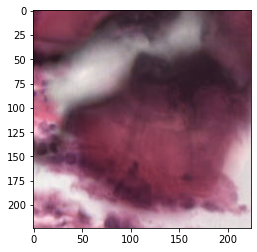

In [215]:
plt.imshow(batch[15].numpy())